In [1]:
from fastai.vision import *
from fastai.metrics import *

In [2]:
import torch 
torch.cuda.manual_seed_all(7)

In [3]:
benign_total = !ls benign
len(benign_total)

124

In [4]:
malig_total = !ls malignant
len(malig_total)

108

In [11]:
import os
import random

random.shuffle(os.listdir('benign'))
random.shuffle(os.listdir('malignant'))

In [12]:
databunch = ImageDataBunch.from_folder('.',
                                  ds_tfms=None, 
                                  valid_pct=0.15,
                                  bs=32, size=224)

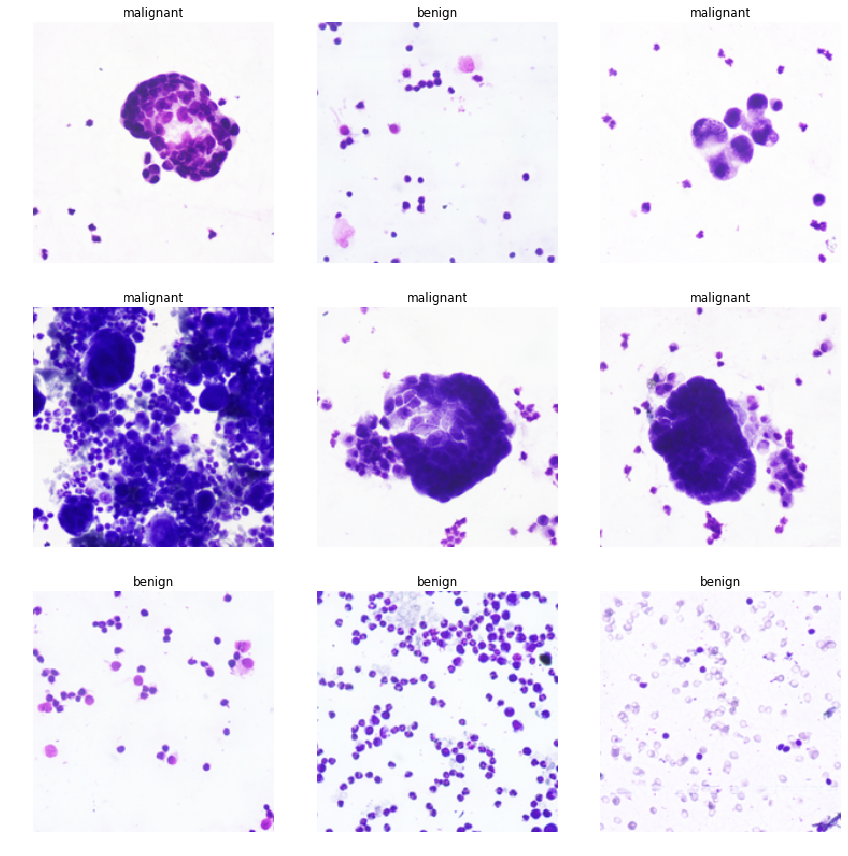

In [13]:
databunch.show_batch(rows=3)

In [14]:
from collections import Counter
import pandas as pd

In [15]:
train_labels = Counter(databunch.train_ds.y).most_common()
pd.DataFrame(train_labels, columns=['Class', 'Observations'])

,Class,Observations
0,benign,104
1,malignant,94


In [16]:
train_labels = Counter(databunch.valid_ds.y).most_common()
pd.DataFrame(train_labels, columns=['Class', 'Observations'])

,Class,Observations
0,benign,20
1,malignant,14


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


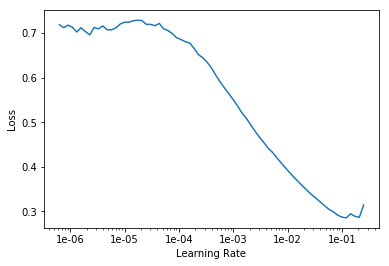

In [17]:
learner = cnn_learner(databunch, models.resnet34, metrics=accuracy)
learner.lr_find()
learner.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.382810,0.351056,0.852941,00:02
1,0.206428,0.506071,0.882353,00:01
2,0.131994,0.410082,0.941176,00:01
3,0.093320,0.358621,0.911765,00:01
4,0.070066,0.282866,0.911765,00:01


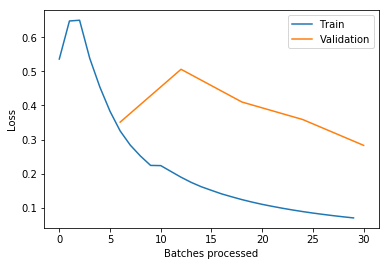

In [18]:
learner.fit_one_cycle(5, max_lr=slice(1e-04, 1e-02))
learner.recorder.plot_losses()

epoch,train_loss,valid_loss,accuracy,time
0,0.545766,0.454028,0.764706,00:02
1,0.351147,0.957688,0.823529,00:02
2,0.232995,0.495336,0.852941,00:02
3,0.176041,0.285201,0.852941,00:02
4,0.137540,0.141609,0.970588,00:02


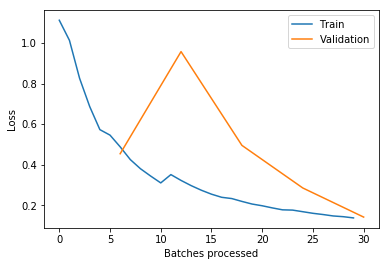

In [19]:
databunch_aug = ImageDataBunch.from_folder('.',
                                  ds_tfms=get_transforms(), 
                                  valid_pct=0.15,
                                  bs=32, size=224)

learner = cnn_learner(databunch_aug, models.resnet34, metrics=accuracy)
learner.fit_one_cycle(5, max_lr=slice(1e-04, 1e-02))
learner.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


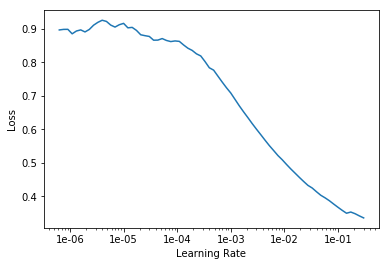

In [21]:
simple_learner = cnn_learner(databunch_aug, models.resnet18, metrics=accuracy)
simple_learner.lr_find();
simple_learner.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.525039,0.325877,0.852941,00:01
1,0.278193,0.734858,0.852941,00:01
2,0.178733,0.656155,0.852941,00:01
3,0.131484,0.362277,0.911765,00:01
4,0.099272,0.187916,0.970588,00:01


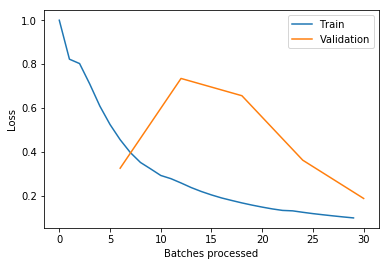

In [22]:
simple_learner.fit_one_cycle(5, max_lr=slice(1e-04, 1e-02))
simple_learner.recorder.plot_losses()

In [24]:
from sklearn.metrics import classification_report

def return_classification_report(learn):
    
    ground_truth = []
    pred_labels = []

    for i in range(len(learn.data.valid_ds)):
        temp_pred = str(learn.predict(learn.data.valid_ds[i][0])[0])
        temp_truth = str(learn.data.valid_ds[i]).split('), ', 1)[1].replace('Category ', '').replace(')', '')
        pred_labels.append(temp_pred)
        ground_truth.append(temp_truth)

    assert len(pred_labels) == len(ground_truth)
    
    return classification_report(ground_truth, pred_labels, target_names=['benign', 'malignant'])

print(return_classification_report(simple_learner))

              precision    recall  f1-score   support

      benign       0.93      1.00      0.97        14
   malignant       1.00      0.95      0.97        20

   micro avg       0.97      0.97      0.97        34
   macro avg       0.97      0.97      0.97        34
weighted avg       0.97      0.97      0.97        34



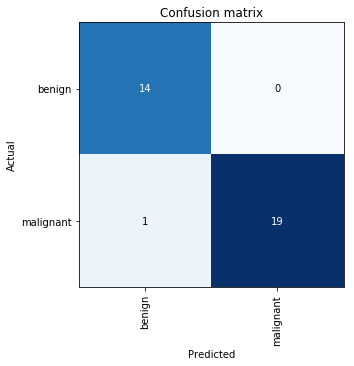

In [25]:
interp = ClassificationInterpretation.from_learner(simple_learner)
interp.plot_confusion_matrix(figsize=(5,5))